# task1：情感分析baseline

- 项目来源：Datawhale情感分析组队学习
- Github：https://github.com/datawhalechina/team-learning-nlp/tree/master/Emotional_Analysis

目标：基于电影评论数据集：[IMDb数据集](http://ai.stanford.edu/~amaas/data/sentiment/)，使用pytorch和torchtext构造一个简单的机器学习模型来预测句子的情绪（即句子表达的情绪是正面还是负面）

## 1.1 简介

由于**循环神经网络（RNN）** 通常在序列模型上表现良好，所以在第一节中，我们将选择RNN作为我们的baseline。RNN每次的输入为一个单词序列：$X=\{x_1, ..., x_T\}$，并为每个输入单词输出一个隐向量：$h$。

我们通过输入当前单词的$x_t$，和上一个隐藏层状态$h_{t-1}$，来生成下一个隐藏层状态$h_t$，用公式表示为：
$$h_t = \text{RNN}(x_t, h_{t-1})$$

一旦当我们获得了最后一个隐藏层的输出：$h_T$（通过输入最后一个单词序列$x_T$和前一个隐藏层状态$h_{T-1}$获得），就可以将它输入一个线性层$f$（也称为全连接层），得到最终的情绪预测结果：$\hat{y} = f(h_T)$.

下图展示了一个例子，当RNN预测为0时，表示预测为负面情绪。橙色部分表示RNN，灰色部分表示线性层。在这个模型中，每个单词使用的是相同的RNN，即每个隐层的参数相同。初始隐层的状态$h_0$是一个初始化为全0的张量。

![](assets/sentiment1.png)

>**注** 这只是我们模型的一个简单表示，省略了一些层和步骤，这些将在后面解释。

## 1.2 数据预处理

数据集为带标签数据集，即数据由评论的原始字符串和情感组成，“pos”表示积极情绪，“neg”表示消极情绪。

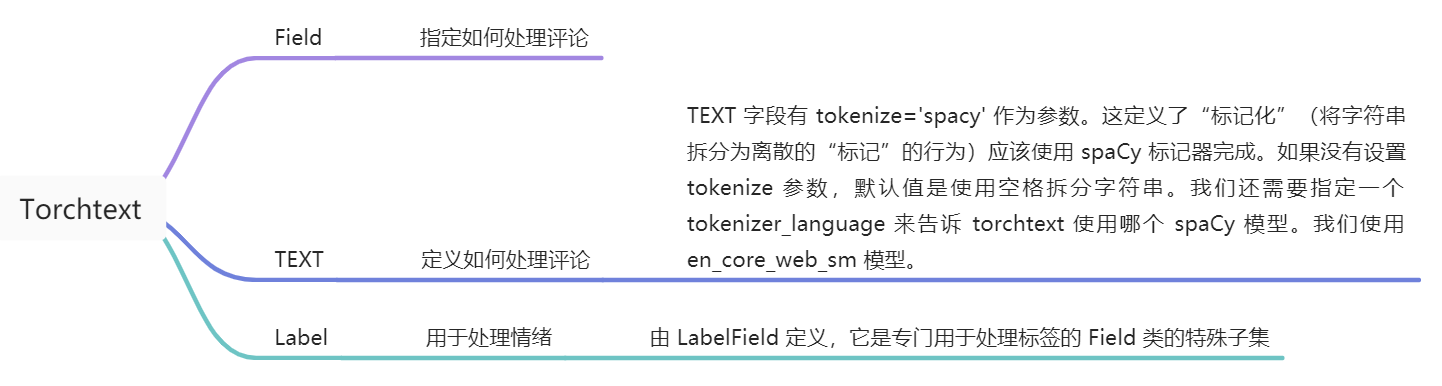

In [1]:
import torch
from torchtext.legacy import data
# 设置随机种子数，该数可以保证随机数是可重复的
SEED = 1234
# 设置种子
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
# 读取数据和标签
TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

`TorchText` 的另一个方便的功能是它支持自然语言处理 (NLP) 中使用的常见数据集。

以下代码自动下载 IMDb 数据集并将其拆分为规范的训练集和测试集，作为 `torchtext.datasets` 对象。 它使用我们之前定义的`Fields`处理数据。 IMDb 数据集包含 50,000 条电影评论，每条评论都标记为正面或负面评论。

In [3]:
#得开vpn才能用运行

from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

查看我们的训练集和测试集大小：

In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 0
Number of testing examples: 0


看一下示例数据：

In [9]:
print(vars(train_data.examples[0]))

IndexError: list index out of range

IMDb 数据集划分了训练集和测试集，这里我们还需要创建一个验证集。 可以使用 `.split()` 方法来做。

默认情况下，数据将按照70%和30%的比例划分为训练集和验证集，可以通过设置`split_ratio`参数来设置训练集和验证集的比例，即 `split_ratio` 为 0.8 意味着 80% 的示例构成训练集，20% 构成验证集。

这里还需要将我们之前设置的随机种子`SEED`传递给 `random_state` 参数，确保我们每次获得相同的训练集和验证集。

In [6]:
import random

train_data, valid_data = train_data.split(split_ratio=0.8 , random_state = random.seed(SEED))

现在我们看一下训练集，验证集和测试集分别有多少数据

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


接下来，我们必须构建一个 *词汇表*。 这是一个查找表，其中数据集中的每个单词都有唯一对应的 *index*（整数）。

我们这样做是因为我们的模型不能对字符串进行操作，只能对数字进行操作。 每个 _index_ 用于为每个词构造一个 _one-hot_ 向量，通常用 $V$ 表示。

![](assets/sentiment5.png)

我们训练集中不同的单词数超过100,000，这意味着我们的one-hot向量超过100,000维，这将大大延长训练时间，甚至不适合在本地运行。

有两种方法可以优化我们的one-hot向量，一种是可以只取前n个出现次数最多的单词作为one-hot的基，另一种是忽略出现次数小于m个的单词。
在本例中，我们使用第一种方法：使用25,000个最常见的单词作为one-hot编码。

这样就会出现一个问题：有些单词在数据集中出现了，但却无法直接进行one-hot编码。这里我们使用一个特别的`<unk>`来编码它们。举个例子，如果我们的句子是"This film is great and I love it"，但是单词"love"不在词汇表中，那么我们将这句话转换成："This film is great and I `<unk>` it"。

下面我们构建词汇表，只保留最常见的 `max_size` 标记。

In [8]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

为什么只在训练集上建立词汇表？因为在测试模型时，都不能以任何方式影响测试集。 当然也不包括验证集，因为希望验证集尽可能地反映测试集。

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


为什么词典大小是25002而不是25000?另外两个额外的token是 `<unk>`和`<pad>`.

当我们将句子输入我们的模型时，我们一次输入一个_batch_，并且批次中的所有句子都需要具有相同的长度。 因此，得设置一个maxlength，为了确保批次中的每个句子的大小相同，填充任何短于maxlength的句子，填充得部分设置为0，大于maxlength的部分直接截取。

![](assets/sentiment6.png)

我们还可以查看词汇表中最常见的单词及其他们在数据集中出现的次数。

In [9]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202789), (',', 192769), ('.', 165632), ('and', 109469), ('a', 109242), ('of', 100791), ('to', 93641), ('is', 76253), ('in', 61374), ('I', 54030), ('it', 53487), ('that', 49111), ('"', 44657), ("'s", 43331), ('this', 42385), ('-', 36979), ('/><br', 35822), ('was', 35035), ('as', 30388), ('with', 29940)]


也可以使用 `stoi` (**s**tring **to** **i**nt) or `itos` (**i**nt **to**  **s**tring) 方法，以下输出text-vocab的前10个词汇。

In [10]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


准备数据的最后一步是创建迭代器. 需要创建验证集，测试集，以及训练集的迭代器, 每一次的迭代都会返回一个batch的数据。

我们将使用一个“BucketIterator”，它是一种特殊类型的迭代器，它将返回一批示例，其中每个样本的长度差不多，从而最小化每个样本的padding数。

如何有gpu的话，当然可以将迭代器返回的张量放在GPU上.可以用torch.device，可以将张量放到gpu或者cpu上。

In [12]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## 1.3 构建模型

下一步就是建立我们接下来要train和evaluate的模型 

在 PyTorch 中使用RNN的模型的时候，创建RNN的时候不是使用RNN类，而是nn.module的子类。

在 `__init__` 我们定义的模型的层数. 三层模型分别是嵌入层，RNN层，最后还有全连接层. 所有层的参数初始化都是随机的，除非对某些参数进行特别设置。
embedding层将稀疏的one-hot转换为密集嵌入到空间的向量.embedding 层是一个简单的单层的全连接层. 这样也减少了输入到RNN的维数，减少了数据的运算的计算量,这里有一种理论是，对评论的情绪有相似影响的词在向量空间中被紧密地映射在一块. 更多信息可以看 [here](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/).

RNN层接受之前的状态$h_{t-1}$和当前输入对应的密集嵌入向量, 这两部分用来计算下一层的隐藏层状态, $h_t$.

![](assets/sentiment7.png)

最终, 最后一层线性层就会得到RNN输出的最后一层隐藏层状态。这层隐藏层状态包含了之前所有的信息，将RNN最后一层的隐藏层状态输入到全连接层，得到 $f(h_T)$, 最终转换成batch_size*num_classes.
forward方法是当我们将训练数据，验证数据集，测试数据集输入到模型时，数据就会传到forward方法，得到模型输出得结果。

在每一个batch中, `text`,是一个大小为 _**[sentence length, batch size]**_的tensor. 这都是每一个句子对应的one-hot向量转换得到的。

而每个句子的one-hot向量都是由对应词典生成索引，然后根据索引值就可以得到每个句子的one-hot向量表示方式。

每一个输入的batch经过embedding层都会被`embedded`, 得到每一个句子的密集向量表示. `embedded`后的向量size为 _**[sentence length, batch size, embedding dim]**_.

在某些框架中，使用RNN需要初始化$h_0$，但在pytorch中不用，默认为全0。
使用 RNN 会返回 2个tensors, `output`和`hidden`。 output的size为_**[sentence length, batch size, hidden dim]**_ and `hidden`的size为_**[1, batch size, hidden dim]**_. `output` 为每一层的隐藏层状态, 而 `hidden` 是最后一层的隐藏层状态. 
小记： `squeeze` 方法, 可以消除维度为1的维度。

其实我们一般用`hidden`就行了,不用管`output` 。最终，通过线性层 `fc`, 产生最终的预测。

In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

下面，我们可以做建立一个RNN的例子

输入维度就是对应one-hot向量的维度, 也等同于词典的维度. 

embedding 维度是可以设置的超参数. 通常设置为 50-250 维度, 某种程度上也和词典大小有关.

隐藏层维度就是最后一层隐藏层的大小. 通常可以设置为100-500维, 这个也会词典大小，任务的复杂程度都有关系

输出的维度就是要分类的类别的数目。

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

也可以输出要训练的参数数目看看.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,105 trainable parameters


## 1.4 训练模型

在模型训练前，先要设置优化器，这里我们选择的是SGD，随机梯度下降计算，model.parameters()表示需要更新的参数，lr为学习率

In [16]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

接下来定义损失函数，BCEWithLogitsLoss一般用来做二分类。

In [17]:
criterion = nn.BCEWithLogitsLoss()

用 `.to`, 可以将张量放到gpu上计算。

In [18]:
model = model.to(device)
criterion = criterion.to(device)

损失函数用来计算损失值，还需要计算准确率的函数。

 将sigmoid层输出的预测结果输入到计算准确率的函数, 取整到最近的整数.大于0.5，就取1。反之取0。

计算出预测的结果和label一致的值，在除以所有的值，就可以得到准确率。

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

`train` 函数迭代所有的样本，每次都是一个batch。

`model.train()` 将model处于 "training 模式", 也会打开 _dropout_ 和 _batch normalization_.
在每一次的batch, 先将梯度清0. 模型的每一个参数都有一个 `grad` 属性， 存储着损失函数计算的梯度值. PyTorch 不会自动删除（或“归零”）从上次梯度计算中计算出的梯度，因此必须手动将其归零。

每次输入, `batch.text`, 到模型中. 只需要调用模型即可. 

用`loss.backward()`计算梯度，更新参数使用的是 `optimizer.step()`。

损失值和准确率在整个 epoch 中累积, `.item()`抽取张量中只含有一个值的张量中的值。

最后，我们返回损失和准确率，在整个 epoch 中取平均值.  `len`可以得到epoch中的batch数

当然在计算的时候，要记得将`LongTensor`转化为 `torch.float`。这是因为 TorchText 默认将张量设置为 `LongTensor`。

In [20]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

`evaluate` 和 `train`相似, 只要将train函数稍微进行修改即可。

`model.eval()` 将模型置于"evaluation 模式", 这会关掉 _dropout_ 和 _batch normalization_. 

在`with no_grad()` 下，不会进行梯度计算. 这会导致使用更少的内存并加快计算速度.

其他函数在`train`中类似,在evaluate中移除了 `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, 因为不再需要更新参数了

In [21]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

接下来创建计算每一个epoch会消耗多少时间的函数。

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

然后，我们通过多个 epoch 来训练模型，每一个 epoch 是对训练和验证集中所有样本的完整传递。

在每个epoch，如果在验证集上的损失值是迄今为止我们所见过的最好的，我们将保存模型的参数，然后在训练完成后我们将在测试集上使用该模型。

In [23]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.694 | Train Acc: 50.12%
	 Val. Loss: 0.696 |  Val. Acc: 50.17%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 49.72%
	 Val. Loss: 0.696 |  Val. Acc: 51.01%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 50.22%
	 Val. Loss: 0.696 |  Val. Acc: 50.87%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 49.94%
	 Val. Loss: 0.696 |  Val. Acc: 49.91%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.693 | Train Acc: 50.07%
	 Val. Loss: 0.696 |  Val. Acc: 51.00%


如上所示，损失并没有真正减少多少，而且准确性很差。 这是由于这是baseline，我们将在下一个notbook中改进的模型的几个问题。

最后，要得到真正关心的指标，测试集上的损失和准确性，参数将从已经训练好的模型中获得，这些参数为我们提供了最好的验证集上的损失。

In [24]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.708 | Test Acc: 47.87%


## 小结

在下一个 notebook, 会有以下优化:
- 压缩填充张量
- 预训练的词嵌入
- 不同的 RNN 架构
- 双向 RNN
- 多层 RNN
- 正则化
- 不同的优化器

最终准确率将达到84%